# Winding numer prediction

## General one-dimensional Hamiltonians with chiral symmetry
One-dimensional Hamiltonians with chiral symmetry can be written in the form
$$
H(k) y= h_x(k)\sigma_x + h_y(k)\sigma_y,
$$
where h_i(k) can be generated using Fourier series
$$
h_i(k) = \sum_{n=0}^c[a_{i,n}\cos(nk) + b_{i,n}\sin(nk)].
$$
The value $c$ determines the highest possible winding number.

## Calculating winding number for a Hamiltonian
The winding number is given by
$$
w = \frac{1}{2\pi i}\oint U^*(k)\partial_k U(K) dk = \frac{1}{2\pi i}\oint dk \frac{d}{dk}\log U(k),
$$
where $U(k)=h_x(k) + ih_y(k)$ and we have used $|U(k)|=1$.

For discrete k, we have
$$
w = -\frac{1}{2\pi}\sum_{n=1}^{N} \Delta\theta (n),
$$
where $\Delta \theta(n) = [\theta (n) - \theta(n-1)]$, modulo $2\pi$ such that $\Delta \theta \in [-\pi,\pi)$ and
$$
\theta(n)=\arg \left [ U \left ( \frac{2 \pi n}{N}\right )\right ].
$$

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [2]:
def hamiltonian_generator(N=32, c=4, normalize=False):
    # Returns a hamiltonian at N + 1 k-points, both 0 and 2 pi are included
    k = np.linspace(0, 2 * np.pi, N + 1)
    while True:
        coef = np.random.rand(c + 1, 4) * 2 - 1  # Fourier coefficients ax, bx, ay, by, [-1, 1]
        h = np.zeros((N + 1, 2))
        for i in range(coef.shape[0]):
            h[:, 0] += coef[i, 0] * np.cos(i * k) + coef[i, 1] * np.sin(i * k)
            h[:, 1] += coef[i, 2] * np.cos(i * k) + coef[i, 3] * np.sin(i * k)
        h_normalized = h / np.linalg.norm(h, axis=1, keepdims=True)
        args = np.angle(h_normalized[:-1, 0] + 1j * h_normalized[:-1, 1])
        arg_diff = (np.roll(args, -1) - args) % (2 * np.pi)
        indices = arg_diff >= np.pi
        arg_diff[indices] = arg_diff[indices] - 2 * np.pi  # Shift to [-pi, pi)
        w = -arg_diff.sum() / (2 * np.pi)
        w = np.round(w)
        yield (h_normalized, w) if normalize else (h, w)

In [3]:
def plot_winding(h, w):
    fig = plt.figure(figsize=(8, 8))
    max_xy = max(np.abs(h[:, 0]).max(), np.abs(h[:, 1]).max())
    max_xy = max_xy + 0.1 * max_xy
    plt.plot([-max_xy, max_xy], [0, 0], c='k')
    plt.plot([0, 0], [-max_xy, max_xy], c='k')
    plt.scatter(0, 0, s=100, marker='x', c='r')
    plt.plot(h[:, 0], h[:, 1], lw=2)
    plt.arrow(h[0, 0], h[0, 1], h[1, 0] - h[0, 0], h[1, 1] - h[0, 1], color='m', width=0.05)
    plt.xlim((-max_xy, max_xy))
    plt.ylim((-max_xy, max_xy))
    plt.title('$w$ = {}'.format(w))
    plt.xlabel('$h_x$')
    plt.ylabel('$h_y$')

## Visualize winding number
Seems to be off by a sign??

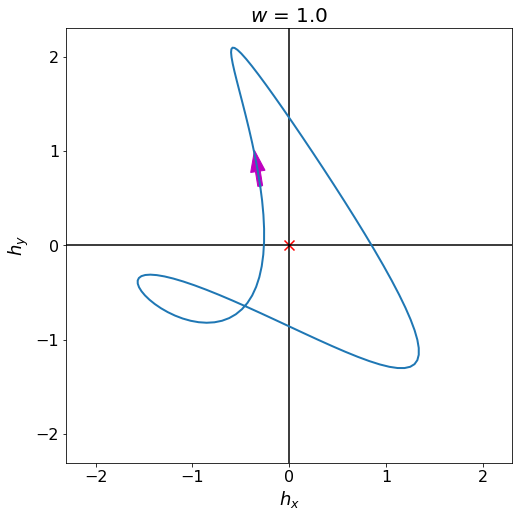

In [4]:
gen_example = hamiltonian_generator(N=100, c=2)
plot_winding(*next(gen_example))

In [5]:
def generate_data(size, dim_k, lower=0, upper=float('inf'), c=4):
    # generating data with specific winding numbers lower bound include upper bound not included
    X = np.zeros((size, dim_k, 2, 1))
    y = np.zeros(size)
    count = 0
    gen = hamiltonian_generator(dim_k - 1, c, normalize=True)
    while count < size:
        h, w = next(gen)
        if lower <= np.abs(w) < upper:
            X[count, :, :, 0] = h
            y[count] = w
            count += 1
    return X, y        

## Generate data

In [15]:
if os.path.exists('data.npz'):
    with np.load('data.npz') as f:
        X_train = f['X_train']
        y_train = f['y_train']
        X_test_1 = f['X_test_1']
        y_test_1 = f['y_test_1']
        X_test_3 = f['X_test_3']
        y_test_3 = f['y_test_3']
        X_test_4 = f['X_test_4']
        y_test_4 = f['y_test_4']
        train_size = X_train.shape[0]
        test_size = X_test_1.shape[0]
        dim_k = X_train.shape[1]
else:
    train_size = 10 ** 5
    test_size = 10 ** 4
    dim_k = 32 + 1
    X_train, y_train = generate_data(train_size, dim_k, 0, 3, c=4)  # Train data -2 <= w <= 2
    X_test_1, y_test_1 = generate_data(test_size, dim_k, 0, 3, c=4)  # Test data -2 <= w <= 2
    X_test_3, y_test_3 = generate_data(test_size, dim_k, 3, 4, c=6)  # Test data w = -3, 3
    X_test_4, y_test_4 = generate_data(test_size, dim_k, 4, 5, c=7)  # Test data w = -4, 4
    np.savez('data.npz', X_train=X_train, y_train=y_train, X_test_1=X_test_1, y_test_1=y_test_1,
             X_test_3=X_test_3, y_test_3=y_test_3, X_test_4=X_test_4, y_test_4=y_test_4)

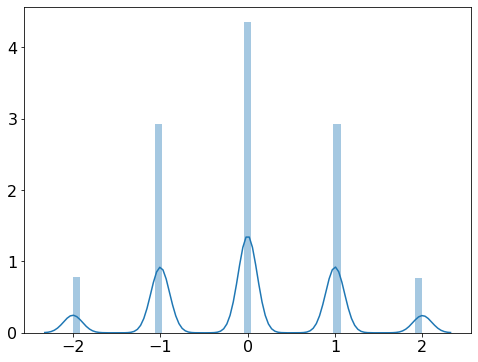

In [20]:
sns.distplot(y_train)

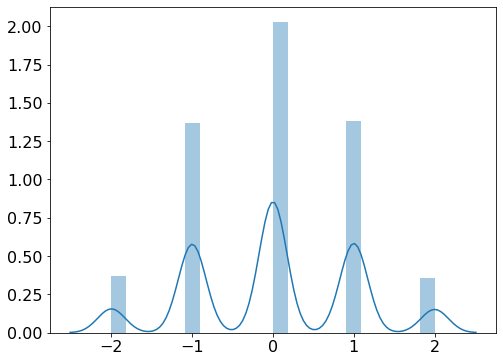

In [22]:
sns.distplot(y_test_1)

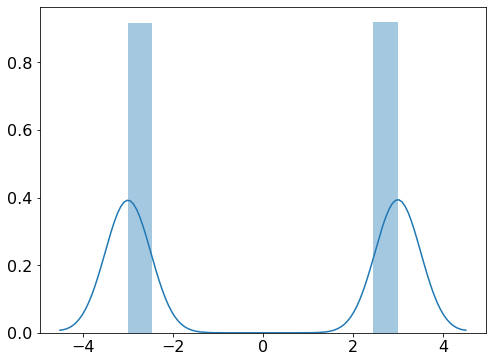

In [23]:
sns.distplot(y_test_3)

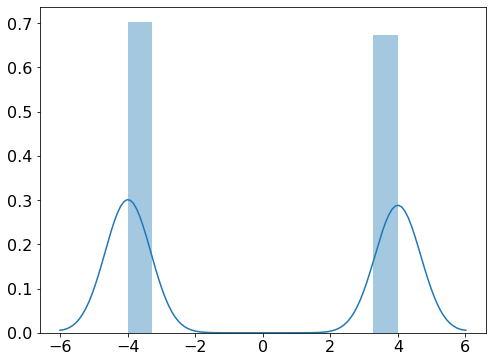

In [24]:
sns.distplot(y_test_4)

## Fully connected network

In [29]:
model_fc = Sequential()
model_fc.add(Dense(40, activation='relu', input_dim=2 * dim_k))
model_fc.add(Dense(32, activation='relu'))
model_fc.add(Dense(2, activation='relu'))
model_fc.add(Dense(1, activation='linear'))

model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                2680      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 4,061
Trainable params: 4,061
Non-trainable params: 0
_________________________________________________________________


In [30]:
batch_size = 50
num_epochs = 40
model_fc.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_fc = model_fc.fit(X_train.reshape(train_size, -1), y_train, batch_size=batch_size, epochs=num_epochs)

Train on 100000 samples
Epoch 1/40
100000/100000 [==============================] - 4s 45us/sample - loss: 0.5280 - mae: 0.5525
Epoch 2/40
100000/100000 [==============================] - 4s 42us/sample - loss: 0.2271 - mae: 0.3762
Epoch 3/40
100000/100000 [==============================] - 4s 43us/sample - loss: 0.1995 - mae: 0.3566
Epoch 4/40
100000/100000 [==============================] - 4s 43us/sample - loss: 0.1890 - mae: 0.3445
Epoch 5/40
100000/100000 [==============================] - 4s 43us/sample - loss: 0.1824 - mae: 0.3376
Epoch 6/40
100000/100000 [==============================] - 4s 45us/sample - loss: 0.1776 - mae: 0.3322
Epoch 7/40
100000/100000 [==============================] - 5s 46us/sample - loss: 0.1729 - mae: 0.3273
Epoch 8/40
100000/100000 [==============================] - 4s 44us/sample - loss: 0.1693 - mae: 0.3233
Epoch 9/40
100000/100000 [==============================] - 5s 46us/sample - loss: 0.1656 - mae: 0.3191
Epoch 10/40
100000/100000 [=============

In [40]:
model_fc.save('prl_fc_model.h5')

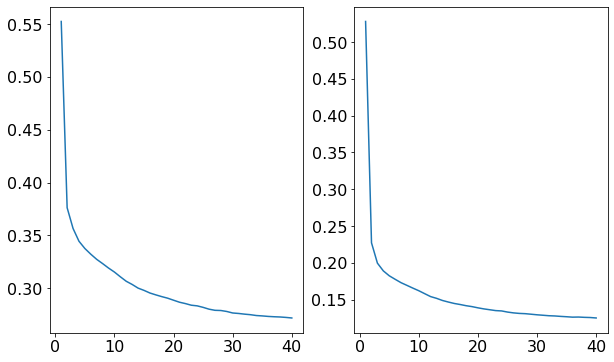

In [31]:
mae_fc = history_fc.history['mae']
loss_fc = history_fc.history['loss']

epochs = range(1, len(mae_fc) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(epochs, mae_fc)
axes[1].plot(epochs, loss_fc)

In [32]:
fc_train_pred = model_fc.predict(X_train.reshape(train_size, -1)).flatten()
fc_test_1_pred = model_fc.predict(X_test_1.reshape(test_size, -1)).flatten()
fc_test_3_pred = model_fc.predict(X_test_3.reshape(test_size, -1)).flatten()
fc_test_4_pred = model_fc.predict(X_test_4.reshape(test_size, -1)).flatten()

print('train accuracy = {}'.format((y_train == fc_train_pred.round()).sum() / len(y_train)))
print('test 1 accuracy = {}'.format((y_test_1 == fc_test_1_pred.round()).sum() / len(y_test_1)))
print('test 3 accuracy = {}'.format((y_test_3 == fc_test_3_pred.round()).sum() / len(y_test_3)))
print('test 4 accuracy = {}'.format((y_test_4 == fc_test_4_pred.round()).sum() / len(y_test_4)))

train accuracy = 0.84845
test 1 accuracy = 0.8318
test 3 accuracy = 0.135
test 4 accuracy = 0.0219


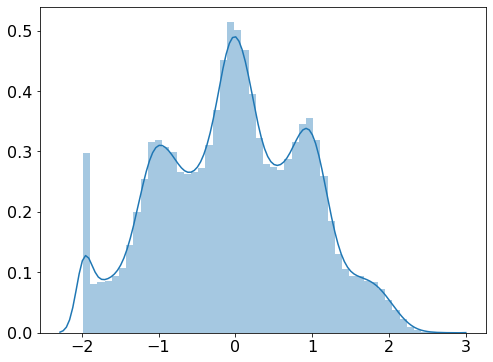

In [37]:
sns.distplot(fc_train_pred)

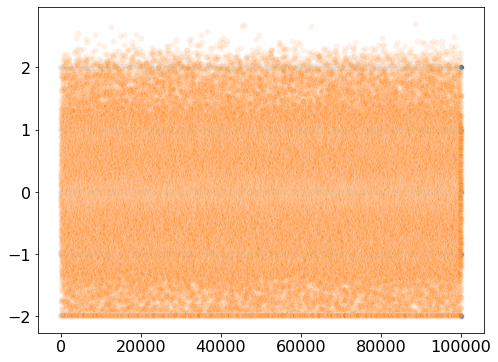

In [38]:
sns.scatterplot(range(len(y_train)), y_train)
sns.scatterplot(range(len(y_train)), fc_train_pred, alpha=0.1)

## Convolutional network

In [41]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=40, kernel_size=2, activation='relu', input_shape=(dim_k, 2, 1)))
model_cnn.add(Conv2D(filters=1, kernel_size=1, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(2, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 1, 40)         200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 1)          41        
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


In [42]:
batch_size = 50
num_epochs = 40
model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

Train on 100000 samples
Epoch 1/40
100000/100000 [==============================] - 9s 94us/sample - loss: 0.3275 - mae: 0.4148
Epoch 2/40
100000/100000 [==============================] - 9s 86us/sample - loss: 0.1060 - mae: 0.2525
Epoch 3/40
100000/100000 [==============================] - 8s 83us/sample - loss: 0.0867 - mae: 0.2264
Epoch 4/40
100000/100000 [==============================] - 9s 91us/sample - loss: 0.0733 - mae: 0.2058
Epoch 5/40
100000/100000 [==============================] - 9s 93us/sample - loss: 0.0637 - mae: 0.1902
Epoch 6/40
100000/100000 [==============================] - 9s 89us/sample - loss: 0.0571 - mae: 0.1785
Epoch 7/40
100000/100000 [==============================] - 9s 86us/sample - loss: 0.0508 - mae: 0.1666
Epoch 8/40
100000/100000 [==============================] - 9s 89us/sample - loss: 0.0476 - mae: 0.1599
Epoch 9/40
100000/100000 [==============================] - 8s 83us/sample - loss: 0.0438 - mae: 0.1526
Epoch 10/40
100000/100000 [=============

In [43]:
model_cnn.save('prl_cnn_model.h5')

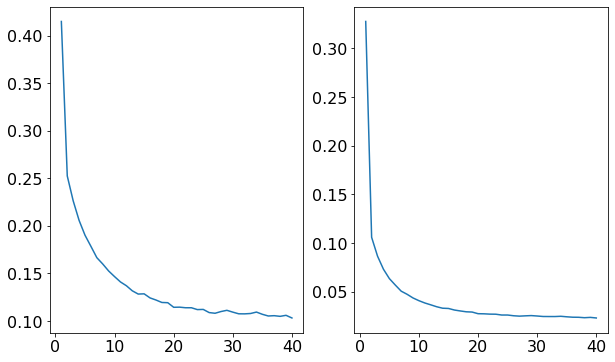

In [44]:
mae_cnn = history_cnn.history['mae']
loss_cnn = history_cnn.history['loss']

epochs = range(1, len(mae_cnn) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(epochs, mae_cnn)
axes[1].plot(epochs, loss_cnn)

In [45]:
cnn_train_pred = model_cnn.predict(X_train).flatten()
cnn_test_1_pred = model_cnn.predict(X_test_1).flatten()
cnn_test_3_pred = model_cnn.predict(X_test_3).flatten()
cnn_test_4_pred = model_cnn.predict(X_test_4).flatten()

print('train accuracy = {}'.format((y_train == cnn_train_pred.round()).sum() / len(y_train)))
print('test 1 accuracy = {}'.format((y_test_1 == cnn_test_1_pred.round()).sum() / len(y_test_1)))
print('test 3 accuracy = {}'.format((y_test_3 == cnn_test_3_pred.round()).sum() / len(y_test_3)))
print('test 4 accuracy = {}'.format((y_test_4 == cnn_test_4_pred.round()).sum() / len(y_test_4)))

train accuracy = 0.98027
test 1 accuracy = 0.9805
test 3 accuracy = 0.9336
test 4 accuracy = 0.8845


The model is able to predict winding number 3 and 4, even though the accuracy is lower than the original paper

## Distribution and scatter plot (train set)

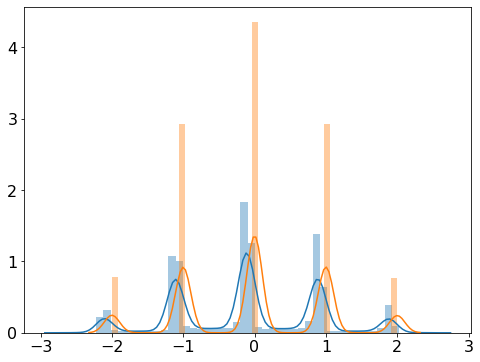

In [48]:
sns.distplot(cnn_train_pred)
sns.distplot(y_train)

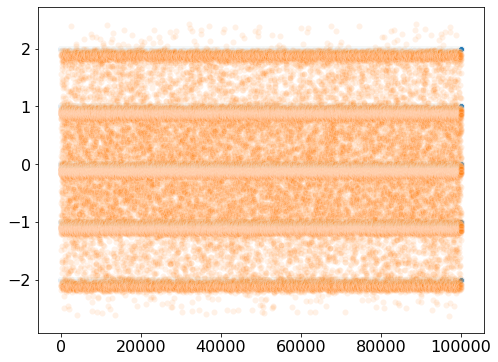

In [49]:
sns.scatterplot(range(len(y_train)), y_train)
sns.scatterplot(range(len(y_train)), cnn_train_pred, alpha=0.1)

## Distribution and scatter plot (test set 1)

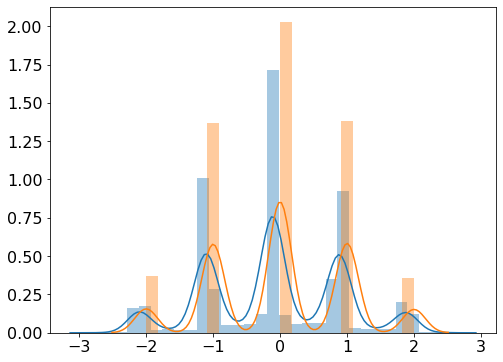

In [50]:
sns.distplot(cnn_test_1_pred)
sns.distplot(y_test_1)

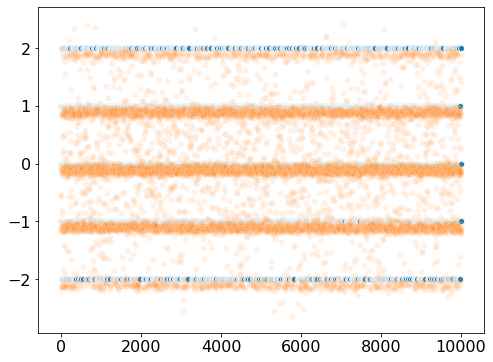

In [51]:
sns.scatterplot(range(len(y_test_1)), y_test_1)
sns.scatterplot(range(len(y_test_1)), cnn_test_1_pred, alpha=0.1)

## Distribution and scatter plot (test set 3)

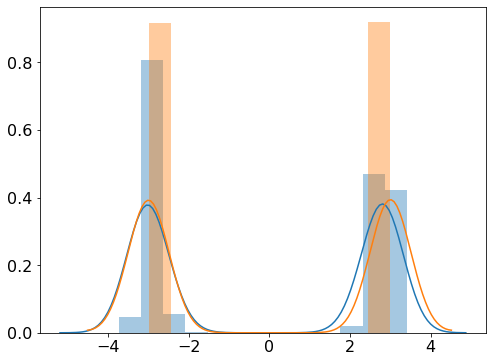

In [52]:
sns.distplot(cnn_test_3_pred)
sns.distplot(y_test_3)

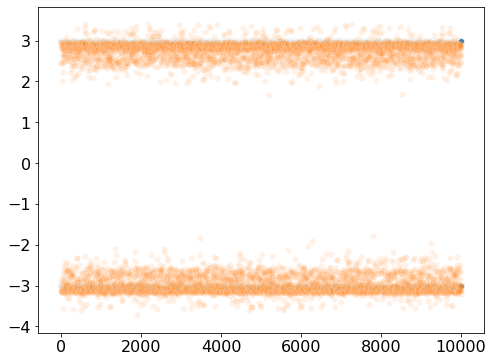

In [53]:
sns.scatterplot(range(len(y_test_3)), y_test_3)
sns.scatterplot(range(len(y_test_3)), cnn_test_3_pred, alpha=0.1)

## Distribution and scatter plot (test set 4)

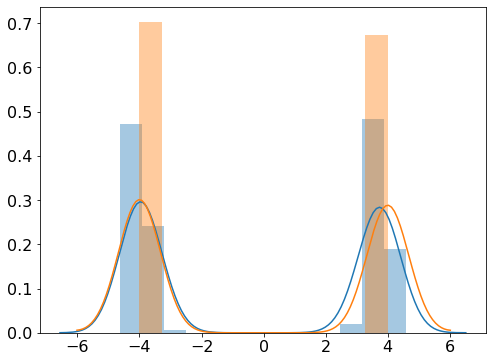

In [54]:
sns.distplot(cnn_test_4_pred)
sns.distplot(y_test_4)

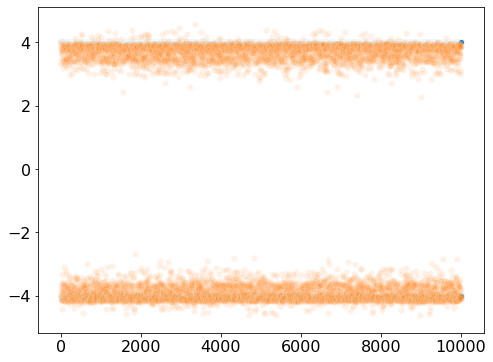

In [55]:
sns.scatterplot(range(len(y_test_4)), y_test_4)
sns.scatterplot(range(len(y_test_4)), cnn_test_4_pred, alpha=0.1)